<a id='top'></a>
# Random Forests

### May 2017

<br>
This is a study for a blog post to appear on [Data Simple](http://luisvalesilva.com/datasimple). It will focus on the theory and scikit-learn implementation of the **Random Forest** machine learning (ML) algorithm.
<br><br>

## Contents

1. [Introduction](#intro)
1. [Decision Trees](#trees)
1. [Ensemble Learning](#ensemble)

<br><br>

<a id='intro'></a>
# 1. Introduction

Random Forests are a popular example of an Ensemble Learning method. Ensemble Learning consists on combining multiple ML models in order to achieve higher predictive performance than could be obtained using either of the individual models alone.

Ensemble Learning methods work best when the models are as diverse as possible, providing complementary predictive performance. One way to achieve this is to combine models built using different ML algorithms, to try to combine models making errors on different training set instances. An alternative approach is to use the same ML algorithm, but to train each model on a different random subset of the training data set. This is the appproach taken by Random Forests: they combine multiple Decision Tree models trained on different subsets of the training data.

The next section provides an overview of the Decision Tree ML algorithm, which is at the core of Random Forests. More on Ensemble Learning theory later. Before moving on, let's generate some toy data using `scikit-learn`'s `make_blobs` function. Let's get a two-dimensional data set with 300 observations evenly split between three classes (let's call them "Yellow", "Blue", and "Red").

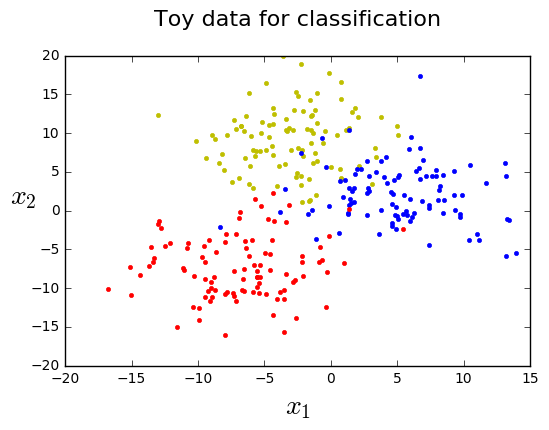

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, n_features=2, centers=3,
                  cluster_std=4, random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.title("Toy data for classification\n", fontsize=16)

plt.figure(figsize=(4, 3))

plt.show()

<a id='trees'></a>
# 2. Decision Trees

Decision Trees are powerful ML algorithms capable of fitting complex data sets. The [Wikipedia page](https://en.wikipedia.org/wiki/Decision_tree_learning) on Decision Tree Learning presents the following definition:

> A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a test on an attribute, each branch represents the outcome of a test, and each leaf (or terminal) node holds a class label. The topmost node in a tree is the root node.

In order to classify a data instance, all you need to do is traverse the flow chart, answering all the tests, until you reach a leaf node. Each test will be a question on a specific feature in the data. The class labeling in the leaf node the new instance ends up in is the predicted class.

Let's grow a Decision Tree on our data set to take a closer look at how this works in practice. `scikit-learn` makes this ridiculously easy, of course.

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the classifier class
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

# Grow a Decision Tree
tree_clf.fit(X, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

We have grown a tree on our 2-D data set. Classifying new examples would be simple:

In [52]:
def predict_class(data_point, classes=['Yellow', 'Blue', 'Red']):
    # Convert to appropriate numpy array
    data_point = np.array(data_point).reshape(1, -1)
    
    # Classify
    result = tree_clf.predict(data_point)
    
    # Print output
    print('Predicted class for point {}: {}'.format(data_point,
                                                    classes[np.asscalar(result)]))
    
predict_class([-5, 10])
predict_class([10, 10])
predict_class([-5, -10])

Predicted class for point [[-5 10]]: Yellow
Predicted class for point [[10 10]]: Blue
Predicted class for point [[ -5 -10]]: Red


In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                feature_names=['x1', 'x2'],
                class_names=['Yellow', 'Blue', 'Red'],
                rounded=True, filled=True)

/Users/luis/anaconda3/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


Generate `.png` image using `graphviz` package:

```
$ dot -Tpng tree.dot -o tree.png
```

Here's the tree visualization.

![Tree](tree.png)

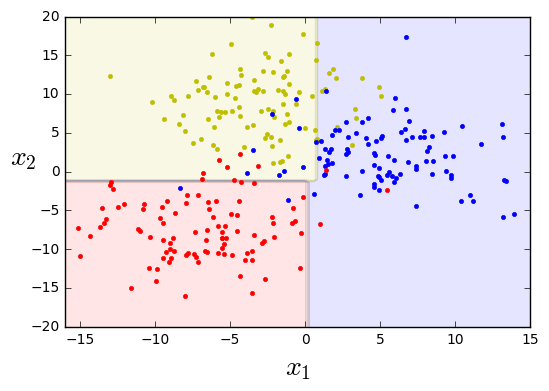

In [4]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-16, 15, -20, 20]):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['y','b','r'])
    plt.contourf(x1, x2, y_pred, alpha=0.1, cmap=custom_cmap, linewidth=1)

    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.1)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.figure(figsize=(8, 4))
    
plot_decision_boundary(tree_clf, X, y)


plt.show()

<a id='ensemble'></a>
# 3. Ensemble Learning

[Back to top](#top)